In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

class CnnAutoencoder(nn.Module):
    def __init__(self, input_channels=1, num_filters=(32, 64, 128), kernel_size=3, latent_dim=128,
                 learning_rate=0.001, optimizer_choice='adam'):
        super(CnnAutoencoder, self).__init__()

        self.learning_rate = learning_rate
        self.kernel_size = kernel_size
        self.num_filters = num_filters
        self.optimizer_choice = optimizer_choice
        self.latent_dim = latent_dim

        # Encoder
        encoder_layers = []
        in_channels = input_channels
        for out_channels in num_filters:
            encoder_layers.append(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=2, padding=kernel_size // 2)
            )
            encoder_layers.append(nn.ReLU())
            in_channels = out_channels
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder
        # Decoder
        decoder_layers = []
        for out_channels in reversed(num_filters):
            decoder_layers.append(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=2, padding=kernel_size // 2, output_padding=1)
            )
            decoder_layers.append(nn.ReLU())
            in_channels = out_channels

        # Update the last layer to use Tanh instead of Sigmoid
        decoder_layers.append(nn.ConvTranspose2d(in_channels, input_channels, kernel_size=kernel_size, stride=1, padding=kernel_size // 2))
        decoder_layers.append(nn.Tanh())  # Changed from Sigmoid to Tanh
        self.decoder = nn.Sequential(*decoder_layers)

        # decoder_layers = []
        # for out_channels in reversed(num_filters):
        #     decoder_layers.append(
        #         nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=2, padding=kernel_size // 2, output_padding=1)
        #     )
        #     decoder_layers.append(nn.ReLU())
        #     in_channels = out_channels
        # decoder_layers.append(nn.ConvTranspose2d(in_channels, input_channels, kernel_size=kernel_size, stride=1, padding=kernel_size // 2))
        # decoder_layers.append(nn.Sigmoid())
        # self.decoder = nn.Sequential(*decoder_layers)

        # Initialize optimizer based on optimizer_choice
        self.optimizer = self._initialize_optimizer()

    def _initialize_optimizer(self):
        if self.optimizer_choice.lower() == 'adam':
            return optim.Adam(self.parameters(), lr=self.learning_rate)
        elif self.optimizer_choice.lower() == 'sgd':
            return optim.SGD(self.parameters(), lr=self.learning_rate)
        else:
            raise ValueError(f"Unsupported optimizer choice: {self.optimizer_choice}")

    def encode(self, x):
        x = self.encoder(x)
        self.encoded_shape = x.shape  # Store shape for decoding
        flattened_size = x.size(1) * x.size(2) * x.size(3)

        # Dynamically create fc_upsample with the correct size
        self.fc_upsample = nn.Linear(flattened_size, self.latent_dim).to(x.device)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layer
        x = self.fc_upsample(x)     # Compress to latent_dim
        return x

    def decode(self, x):
        # Define fc_downsample to expand from latent_dim back to flattened size
        if not hasattr(self, 'fc_downsample'):
            flattened_size = self.encoded_shape[1] * self.encoded_shape[2] * self.encoded_shape[3]
            self.fc_downsample = nn.Linear(self.latent_dim, flattened_size).to(x.device)

        x = self.fc_downsample(x)
        x = x.view(x.size(0), *self.encoded_shape[1:])  # Reshape to encoded shape
        x = self.decoder(x)
        return x

    def forward(self, x):
        latent = self.encode(x)
        reconstructed = self.decode(latent)
        return reconstructed


In [ ]:
!pip install patool
import patoolib

patoolib.extract_archive('fashionmnist.zip', outdir='/content')

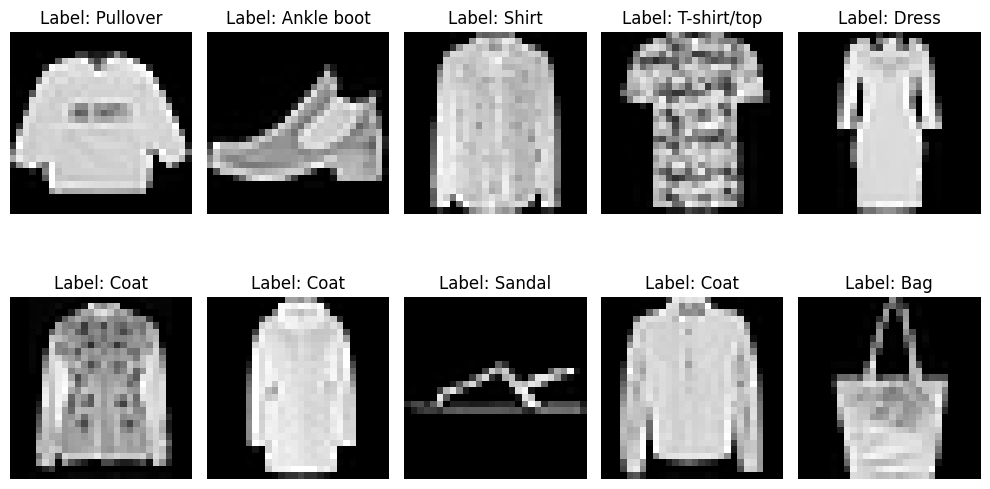

Clothing Types:
0: T-shirt/top
1: Trouser
2: Pullover
3: Dress
4: Coat
5: Sandal
6: Shirt
7: Sneaker
8: Bag
9: Ankle boot


In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have downloaded the 'fashion-mnist_train.csv' and 'fashion-mnist_test.csv' files

fashion_train = pd.read_csv("/content/fashion-mnist_train.csv")
fashion_test = pd.read_csv("/content/fashion-mnist_test.csv")


clothing_types = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}


def visualize_images(data, num_images=10):
  """
  Visualizes a random sample of images from the given data.
  """
  plt.figure(figsize=(10, 6))
  for i in range(num_images):
    # Reshape image data from a 784-dimensional vector to a 28x28 image
    image = data.iloc[i, 1:].values.reshape(28, 28)
    label = clothing_types[data.iloc[i, 0]]

    plt.subplot(2, 5, i+1)
    plt.imshow(image, cmap="gray")
    plt.title(f"Label: {label}")
    plt.axis("off")
  plt.tight_layout()
  plt.show()

visualize_images(fashion_train)  # Visualize training images


print("Clothing Types:")
for class_label, clothing_type in clothing_types.items():
  print(f"{class_label}: {clothing_type}")

In [7]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import Dataset

def train_model(model, train_loader, val_loader, num_epochs=20):
    criterion = nn.MSELoss()
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for images, _ in train_loader:
            images = images.to(device)
            model.optimizer.zero_grad()
            reconstructed = model(images)
            loss = criterion(reconstructed, images)
            loss.backward()
            model.optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)
                reconstructed = model(images)
                loss = criterion(reconstructed, images)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

    return train_losses, val_losses

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations and load dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])



# Load the data
data = pd.read_csv('/content/fashion-mnist_train.csv')
class FashionMNISTDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Separate the label from the pixel values
        label = self.data.iloc[idx, 0]
        image_array = self.data.iloc[idx, 1:].values.astype(np.uint8).reshape(28, 28)
        image = Image.fromarray(image_array, mode='L')

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        return image, label

# Instantiate the dataset with transformations
dataset = FashionMNISTDataset(data, transform=transform)

# Split 70% for training and 30% for temp set (validation + test)
train_data, temp_data = train_test_split(dataset, test_size=0.3, random_state=42)

# Split the temp set into 10% for validation and 20% for test
val_data, test_data = train_test_split(temp_data, test_size=2/3, random_state=42)

# train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
# val_size = int(0.1 * len(train_dataset))
# train_size = len(train_dataset) - val_size
# train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)


# Hyperparameter configurations
configs = [
    {"learning_rate": 0.001, "kernel_size": 3, "num_filters": (32, 64, 128), "optimizer_choice": 'adam'},
    {"learning_rate": 0.0005, "kernel_size": 3, "num_filters": (32, 64),  "optimizer_choice": 'adam'},
    {"learning_rate": 0.001, "kernel_size": 5, "num_filters": (32, 64, 128), "optimizer_choice": 'sgd'}
]

train_losses_all, val_losses_all = [], []
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training loop
for config in configs:
    print(f"\nTraining with config: {config}")
    model = CnnAutoencoder(**config).to(device)
    train_losses, val_losses = train_model(model, train_loader, val_loader)
    train_losses_all.append(train_losses)
    val_losses_all.append(val_losses)


# Plot the train and validation losses for each configuration
for i, config in enumerate(configs):
    plt.plot(train_losses_all[i], label=f"Train Loss - Config {i+1}")
    plt.plot(val_losses_all[i], label=f"Val Loss - Config {i+1}")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss for Different Configurations")
plt.show()



Training with config: {'learning_rate': 0.001, 'kernel_size': 3, 'num_filters': (32, 64, 128), 'optimizer_choice': 'adam'}
Epoch 1, Train Loss: 0.2478, Val Loss: 0.2192
Epoch 2, Train Loss: 0.2100, Val Loss: 0.1985
Epoch 3, Train Loss: 0.1914, Val Loss: 0.1857
Epoch 4, Train Loss: 0.1847, Val Loss: 0.1822
Epoch 5, Train Loss: 0.1815, Val Loss: 0.1817
Epoch 6, Train Loss: 0.1791, Val Loss: 0.1774
Epoch 7, Train Loss: 0.1776, Val Loss: 0.1782
Epoch 8, Train Loss: 0.1764, Val Loss: 0.1747
Epoch 9, Train Loss: 0.1742, Val Loss: 0.1737
Epoch 10, Train Loss: 0.1735, Val Loss: 0.1732
Epoch 11, Train Loss: 0.1723, Val Loss: 0.1708
Epoch 12, Train Loss: 0.1718, Val Loss: 0.1708
Epoch 13, Train Loss: 0.1706, Val Loss: 0.1700
Epoch 14, Train Loss: 0.1687, Val Loss: 0.1688
Epoch 15, Train Loss: 0.1684, Val Loss: 0.1659
Epoch 16, Train Loss: 0.1664, Val Loss: 0.1653
Epoch 17, Train Loss: 0.1651, Val Loss: 0.1651
Epoch 18, Train Loss: 0.1642, Val Loss: 0.1628
Epoch 19, Train Loss: 0.1632, Val Loss:

KeyboardInterrupt: 

In [ ]:
Visualisation

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader , Dataset
from torchvision import datasets, transforms
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, val_loader, num_epochs=30):
    criterion = nn.MSELoss()
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for images, _ in train_loader:
            images = images.to(device)
            model.optimizer.zero_grad()
            reconstructed = model(images)
            loss = criterion(reconstructed, images)
            loss.backward()
            model.optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)
                reconstructed = model(images)
                loss = criterion(reconstructed, images)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

    return train_losses, val_losses

# Define transformations and load dataset
# transform = transforms.Compose([
#     transforms.Resize((32, 32)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    # Normalize to [0, 1] range
    transforms.Normalize((0.5,), (0.5,))
])


# Define the dataset class
class FashionMNISTDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Separate the label and image data
        label = self.data.iloc[idx, 0]
        image_array = self.data.iloc[idx, 1:].values.astype(np.uint8).reshape(28, 28)
        image = Image.fromarray(image_array, mode='L')

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        return image, label

# Load the data from CSV
data = pd.read_csv('/content/fashion-mnist_train.csv')
print(data.isnull().sum())

# Define the transformations for data augmentation
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] for Fashion MNIST
])

# Instantiate the dataset with transformations
dataset = FashionMNISTDataset(data, transform=transform)

# Split the dataset: 70% for training, 15% for validation, and 15% for testing
train_data, temp_data = train_test_split(dataset, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.67, random_state=42)

# Create DataLoaders for each set
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

images, labels = next(iter(test_loader))
min_val = images.min().item()
max_val = images.max().item()


print(f"Minimum pixel value: {min_val}")
print(f"Maximum pixel value: {max_val}")
# Verify sizes
print(f"Training samples: {len(train_data)}, Validation samples: {len(val_data)}, Test samples: {len(test_data)}")


label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    1
pixel781    1
pixel782    1
pixel783    1
pixel784    1
Length: 785, dtype: int64


<ipython-input-41-96113d1d726d>:71: RuntimeWarning: invalid value encountered in cast
  image_array = self.data.iloc[idx, 1:].values.astype(np.uint8).reshape(28, 28)


Minimum pixel value: -1.0
Maximum pixel value: 1.0
Training samples: 3022, Validation samples: 427, Test samples: 869


Epoch 1, Train Loss: 0.5563, Val Loss: 0.3713
Epoch 2, Train Loss: 0.3308, Val Loss: 0.3002
Epoch 3, Train Loss: 0.2766, Val Loss: 0.2631
Epoch 4, Train Loss: 0.2502, Val Loss: 0.2431
Epoch 5, Train Loss: 0.2361, Val Loss: 0.2376
Epoch 6, Train Loss: 0.2312, Val Loss: 0.2333
Epoch 7, Train Loss: 0.2291, Val Loss: 0.2288
Epoch 8, Train Loss: 0.2261, Val Loss: 0.2271
Epoch 9, Train Loss: 0.2260, Val Loss: 0.2245
Epoch 10, Train Loss: 0.2253, Val Loss: 0.2234
Epoch 11, Train Loss: 0.2234, Val Loss: 0.2286
Epoch 12, Train Loss: 0.2227, Val Loss: 0.2247
Epoch 13, Train Loss: 0.2215, Val Loss: 0.2280
Epoch 14, Train Loss: 0.2217, Val Loss: 0.2282
Epoch 15, Train Loss: 0.2199, Val Loss: 0.2206
Epoch 16, Train Loss: 0.2207, Val Loss: 0.2180
Epoch 17, Train Loss: 0.2207, Val Loss: 0.2261
Epoch 18, Train Loss: 0.2192, Val Loss: 0.2226
Epoch 19, Train Loss: 0.2181, Val Loss: 0.2217
Epoch 20, Train Loss: 0.2180, Val Loss: 0.2177
Epoch 21, Train Loss: 0.2194, Val Loss: 0.2166
Epoch 22, Train Loss: 

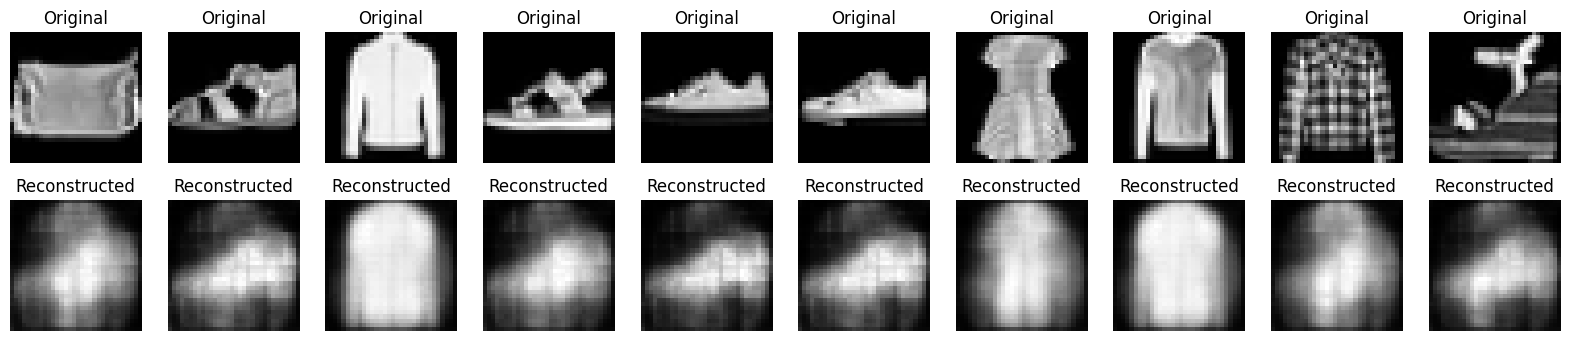

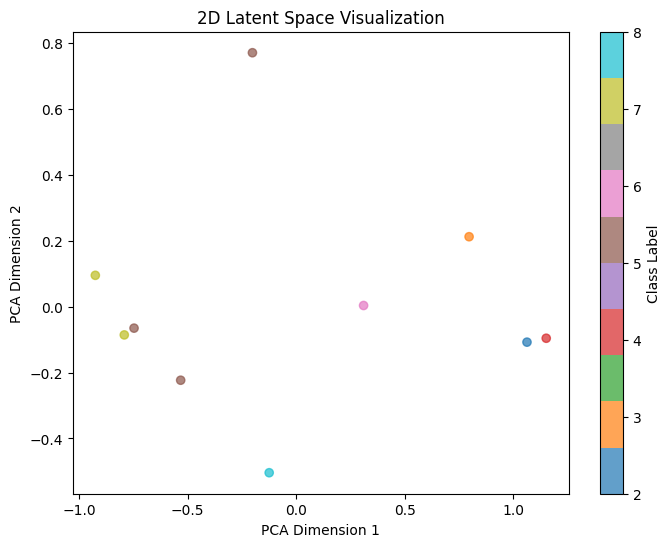

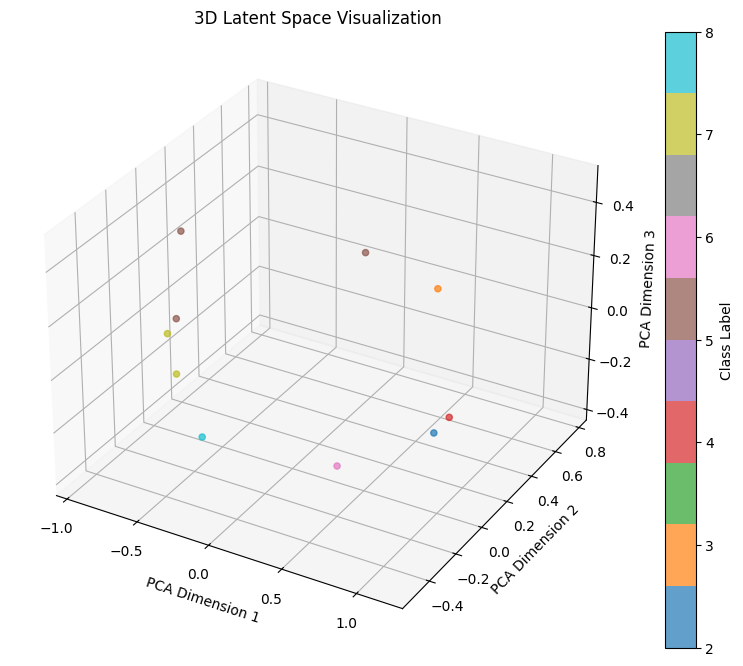

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import torch
from mpl_toolkits.mplot3d import Axes3D

# Hyperparameters for the model
learning_rate = 0.0005
kernel_size = 3
num_filters = (32, 64, 128)
latent_dim = 128
optimizer_choice = 'adam'

# Instantiate the model
model = CnnAutoencoder(
    learning_rate=learning_rate,
    kernel_size=kernel_size,
    num_filters=num_filters,
    latent_dim=latent_dim,
    optimizer_choice=optimizer_choice
)

train_model(model, train_loader, val_loader)
# {'learning_rate': 0.0005, 'kernel_size': 3, 'num_filters': (32, 64), 'optimizer_choice': 'adam'}
# Set the model to evaluation mode
model.eval()

# Load a batch of test data
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)
images, labels = next(iter(test_loader))
min_val = images.min().item()
max_val = images.max().item()

print(f"Minimum pixel value: {min_val}")
print(f"Maximum pixel value: {max_val}")

# Forward pass through the model to get reconstructed images and latent representations
with torch.no_grad():
    latent = model.encode(images)
    reconstructed = model(images)

# 1. Visualize Original and Reconstructed Images
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    # Original images
    axs[0, i].imshow(images[i].squeeze(), cmap='gray')
    axs[0, i].axis('off')
    axs[0, i].set_title("Original")

    # Reconstructed images
    axs[1, i].imshow(reconstructed[i].squeeze(), cmap='gray')
    # reconstructed_img = (reconstructed[i].cpu().view(32, 32) * 0.5 + 0.5).clamp(0, 1)
    # plt.imshow(reconstructed_img, cmap='gray')
    axs[1, i].imshow(reconstructed[i].cpu().view(32, 32), cmap="gray")
    axs[1, i].axis('off')
    axs[1, i].set_title("Reconstructed")

plt.show()

# 2. Visualize Latent Representations (2D and 3D)
# Reduce latent dimensions to 2D and 3D using PCA
latent_np = latent.cpu().numpy()
labels_np = labels.cpu().numpy()

# 2D PCA
pca_2d = PCA(n_components=2)
latent_2d = pca_2d.fit_transform(latent_np)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels_np, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label="Class Label")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.title("2D Latent Space Visualization")
plt.show()

# 3D PCA
pca_3d = PCA(n_components=3)
latent_3d = pca_3d.fit_transform(latent_np)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(latent_3d[:, 0], latent_3d[:, 1], latent_3d[:, 2], c=labels_np, cmap='tab10', alpha=0.7)
ax.set_xlabel("PCA Dimension 1")
ax.set_ylabel("PCA Dimension 2")
ax.set_zlabel("PCA Dimension 3")
plt.colorbar(scatter, ticks=range(10), label="Class Label")
plt.title("3D Latent Space Visualization")
plt.show()


- Sufficient separation between different label points suggests that the encoder has learned meaningful features for each class. This means that the features captured by the encoder component effectively represent the unique characteristics of each class, even after dimensionality reduction.
- Classifier (like K-Nearest Neighbors) can more easily distinguish between different classes. Points from the same class cluster together, while points from different classes are distinct.
This improves the accuracy of the classifier since there is less overlap between classes, reducing the chance of misclassification.

## Hyperparameter Training (done before)

In [ ]:

Training with config: {'learning_rate': 0.001, 'kernel_size': 3, 'num_filters': (32, 64, 128), 'optimizer_choice': 'adam'}
Epoch 1, Train Loss: 0.2478, Val Loss: 0.2192
Epoch 2, Train Loss: 0.2100, Val Loss: 0.1985
Epoch 3, Train Loss: 0.1914, Val Loss: 0.1857
Epoch 4, Train Loss: 0.1847, Val Loss: 0.1822
Epoch 5, Train Loss: 0.1815, Val Loss: 0.1817
Epoch 6, Train Loss: 0.1791, Val Loss: 0.1774
Epoch 7, Train Loss: 0.1776, Val Loss: 0.1782
Epoch 8, Train Loss: 0.1764, Val Loss: 0.1747
Epoch 9, Train Loss: 0.1742, Val Loss: 0.1737
Epoch 10, Train Loss: 0.1735, Val Loss: 0.1732
Epoch 11, Train Loss: 0.1723, Val Loss: 0.1708
Epoch 12, Train Loss: 0.1718, Val Loss: 0.1708
Epoch 13, Train Loss: 0.1706, Val Loss: 0.1700
Epoch 14, Train Loss: 0.1687, Val Loss: 0.1688
Epoch 15, Train Loss: 0.1684, Val Loss: 0.1659
Epoch 16, Train Loss: 0.1664, Val Loss: 0.1653
Epoch 17, Train Loss: 0.1651, Val Loss: 0.1651
Epoch 18, Train Loss: 0.1642, Val Loss: 0.1628
Epoch 19, Train Loss: 0.1632, Val Loss: 0.1621
Epoch 20, Train Loss: 0.1625, Val Loss: 0.1611

Training with config: {'learning_rate': 0.0005, 'kernel_size': 3, 'num_filters': (32, 64), 'optimizer_choice': 'adam'}
Epoch 1, Train Loss: 0.2876, Val Loss: 0.2330
Epoch 2, Train Loss: 0.2312, Val Loss: 0.2282
Epoch 3, Train Loss: 0.2272, Val Loss: 0.2254
Epoch 4, Train Loss: 0.2253, Val Loss: 0.2225
Epoch 5, Train Loss: 0.2230, Val Loss: 0.2205
Epoch 6, Train Loss: 0.2207, Val Loss: 0.2202
Epoch 7, Train Loss: 0.2199, Val Loss: 0.2207
Epoch 8, Train Loss: 0.2179, Val Loss: 0.2174
Epoch 9, Train Loss: 0.2169, Val Loss: 0.2151
Epoch 10, Train Loss: 0.2157, Val Loss: 0.2159
Epoch 11, Train Loss: 0.2148, Val Loss: 0.2133
Epoch 12, Train Loss: 0.2131, Val Loss: 0.2122
Epoch 13, Train Loss: 0.2112, Val Loss: 0.2100
Epoch 14, Train Loss: 0.2087, Val Loss: 0.2082
Epoch 15, Train Loss: 0.2049, Val Loss: 0.2049
Epoch 16, Train Loss: 0.2013, Val Loss: 0.1988
Epoch 17, Train Loss: 0.1983, Val Loss: 0.2063
Epoch 18, Train Loss: 0.1956, Val Loss: 0.1970
Epoch 19, Train Loss: 0.1940, Val Loss: 0.1943
Epoch 20, Train Loss: 0.1925, Val Loss: 0.1935

Training with config: {'learning_rate': 0.001, 'kernel_size': 5, 'num_filters': (32, 64, 128), 'optimizer_choice': 'sgd'}
Epoch 1, Train Loss: 0.5370, Val Loss: 0.4696
Epoch 2, Train Loss: 0.4642, Val Loss: 0.4624

## Keeping Latent Space Constant
![image.png](https://prod-files-secure.s3.us-west-2.amazonaws.com/b645578c-5132-470c-860e-afacbb53fd5c/992f541d-ebfe-4780-8ba1-b598ed3beb76/image.png)
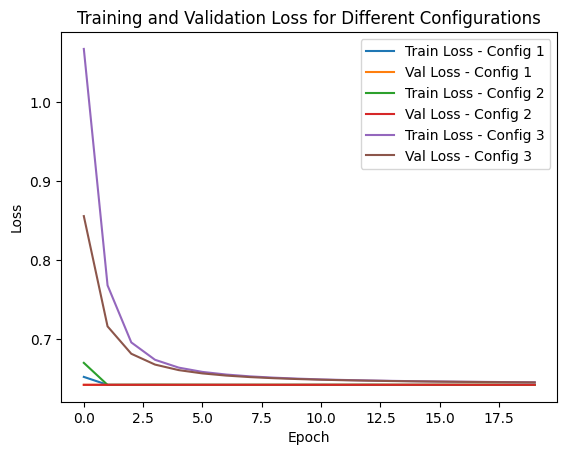

In [ ]:

# Hyperparameter configurations
configs = [
    {"learning_rate": 0.001, "kernel_size": 3, "num_filters": (32, 64, 128), "optimizer_choice": 'adam'},
    {"learning_rate": 0.0005, "kernel_size": 3, "num_filters": (32, 64),  "optimizer_choice": 'adam'},
    {"learning_rate": 0.001, "kernel_size": 5, "num_filters": (32, 64, 128), "optimizer_choice": 'sgd'}
]




## Observations:
The training loss decreases steadily, showing a smooth downward trend, indicating effective learning.
Validation loss also consistently decreases and stabilizes, suggesting good generalization.

**Analysis:** This configuration, with three layers and the Adam optimizer, shows efficient convergence, achieving low training and validation loss. The additional depth (128 filters in the last layer) helps the model capture more complex patterns in the data, leading to better performance.


## Best Model:
config: {'learning_rate': 0.001, 'kernel_size': 3, 'num_filters': (32, 64, 128), 'optimizer_choice': 'adam'}